# Optimize the set of samples for limited learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    benchmark_ind = [21, 276, 1397, 1409, 257, 537, 83, 96, 94, 247] # ths one grants 70% accuracy
    
C = Const()

In [9]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [10]:
# Collect limited datasets

def find_data(ytrain, nrows):
    hist = [0]*10
    indices = np.zeros((nrows, 10), dtype=int)
    i = 0
    while min(hist) < nrows:
        label = np.argmax(ytrain[i])
        if hist[label]<nrows:
            indices[hist[label], label] = i
            hist[label] += 1
        i += 1
    return indices
    
indices = find_data(ytrain, 20)
print(indices)

[[  1   3   5   7   2   0  13  15  17   4]
 [ 21   6  16  10   9  11  18  29  31  19]
 [ 34   8  25  12  20  35  32  38  41  22]
 [ 37  14  28  27  26  47  36  42  46  33]
 [ 51  23  76  30  53  65  39  52  55  43]
 [ 56  24  82  44  58 100  62  71  85  45]
 [ 63  40 109  49  60 132  66  79  94  48]
 [ 68  59 117  50  61 138  73  84  97  54]
 [ 69  67 120  74  64 145  83  91 125  57]
 [ 75  70 122  86  89 173  90  96 137  80]
 [ 81  72 143  98  92 175  93 101 144  87]
 [ 88  77 159 107 115 182 106 103 146 110]
 [ 95  78 161 111 127 191 126 123 160 116]
 [108  99 171 130 131 219 129 140 188 133]
 [114 102 178 135 139 236 147 141 197 153]
 [118 104 180 136 142 239 151 148 202 154]
 [119 105 187 149 150 244 155 158 225 162]
 [121 112 189 157 163 259 165 168 240 167]
 [156 113 190 179 164 266 186 185 245 170]
 [169 124 199 181 166 273 204 193 265 172]]


In [12]:
def _compile_model(model):
    """Helper function, just to not write this out every time."""
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])    
    return model

def build_model():
    """Build a naive model, then compile."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    return _compile_model(model)

def reset_last_layer(model):
    """Reset last layer (actually copy all except the last layer)."""
    model2 = tf.keras.Sequential()
    for layer in model.layers[:-1]: # Copy from input model
        model2.add(layer)
    model2.add(tf.keras.layers.Dense(C.nclasses, activation='softmax')) # Last layer
    for layer in model2.layers[:-1]:
        layer.trainable = False
    return _compile_model(model2)

model = build_model()
#model.summary()

In [13]:
class PrintDot(tf.keras.callbacks.Callback):
    """Helper function to report running loss during training."""
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')

In [21]:
def train_model(model, x, y, epochs=40):
    hist = model.fit(x, y,
                      batch_size=1024,
                      epochs=40,
                      verbose=0,
                      validation_data=(xtest, ytest)) # Note that it's not validation, but rather test data

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    score = model.evaluate(xtest, ytest, verbose=0)
    return score[1]

Accuracy: 
0.551
0.4699
0.4925
0.5124
0.4109
0.4321
0.4009
0.5006
0.5315
0.4634
0.5654
0.6087
0.4548
0.5306
0.5404
0.4453
0.4431
0.5491
0.5186
0.4759


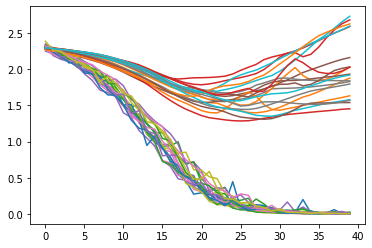

In [18]:
# Overfit with partial data:

print('Accuracy: ')
for i in range(indices.shape[0]):
    model = build_model()
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]])
    print(acc)

Accuracy: 
0.1157
0.0884
0.0688
0.095
0.127
0.1606
0.1104
0.1246
0.1085
0.085
0.1073
0.1589
0.1196
0.1303
0.0949
0.0938
0.0881
0.1279
0.1106
0.0899


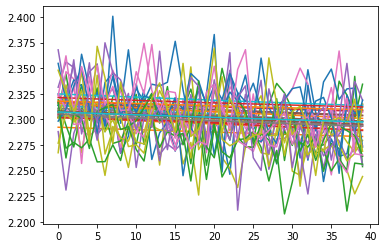

In [22]:
# Randomize all layers, but only train last layer

print('Accuracy: ')
for i in range(indices.shape[0]):
    model = build_model()
    model = reset_last_layer(model)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.0928
0.1059
0.1715
0.1379
0.1197
0.1872
0.1111
0.1108
0.1474
0.2026
0.1693
0.1474
0.128
0.135
0.0851
0.0769
0.0788
0.1022
0.0967
0.12


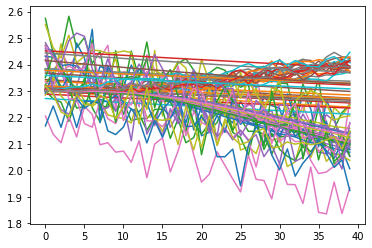

In [23]:
# Pre-training on random data:
print('Accuracy: ')
for i in range(indices.shape[0]):
    randints = np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)
    model = build_model()    
    acc = train_model(model, xtrain, ytrain[randints], epochs=300)
    model = reset_last_layer(model)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

# Summary

* Overfit 10 labels: 0.6266 accuracy
* Train last layer with random other layers: 0.3967
* Pre-train on random labels, then train last layer: 0.345 (counter-intuitively, the result is worse as the representation is better, in a way, and we reach perfect fit of 10 labels before it becomes generalizable for the set)
* Post-fit for 10 labels: 0.3787 (not taht much difference, compared to only training last layer, as the fit on this small subset is almost perfect, so there's nothing to optimize in earlier layers)

**Conclusion:** pre-training on random labels makes the model more trainable, but doesn't necessarily create a useful representation, and as such, it actually hurts performance in a "generalize from a few labels" task.